# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [8]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


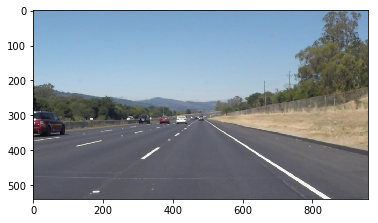

In [9]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [10]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #Reshape from 3d to 2d array
    lines = lines.reshape(-1,lines.shape[2]) 
    #Calcualte Slopes
    slopes = (lines[:,3]-lines[:,1])/(lines[:,2]-lines[:,0])
    #remove garbage values 
    slopes = slopes[~np.isnan(slopes) & ~np.isinf(slopes)] 

    
    right_lines = np.array([])
    left_lines = np.array([])
    
    #Split lines in right and left based on slope and point position
    
    for x in range(len(slopes)): 
        x_center = img.shape[1]/2
        x1, y1, x2, y2 = lines[x] 
        if slopes[x] > 0 and x1 >x_center and x2>x_center:
            right_lines = np.append(right_lines,lines[x])
        elif slopes[x] < 0 and x1 <x_center and x2<x_center:
             left_lines = np.append(left_lines,lines[x])
    
    #List of coordinates
    right_lines = right_lines.reshape(-1,2)
    left_lines  = left_lines.reshape(-1,2)
    
    #Calculate best fit based on leniar regression
    
    if(len(right_lines[:,0])>0): #expected non-empty vector for x
        global right 
        right = np.poly1d(np.polyfit(right_lines[:,0], right_lines[:,1], 1)) # 0 1 leniar
    if(len(left_lines[:,0])>0):
        global left
        left  = np.poly1d(np.polyfit(left_lines[:,0] , left_lines[:,1] , 1))   
    
    #Define y endpoints 
    
    y1 = int(img.shape[0])
    y2 = int(img.shape[0]*.62)
    
    # Calculate x1,x2 based on endpoints
    
    #right lane
    r_x1 = (right - y1).r
    r_x2 = ((right - y2).r)
    #left lane
    l_x1 = ((left  - y1).r)
    l_x2 = ((left - y2).r)
    
    r1 = (int(r_x1), y1)
    r2 = (int(r_x2), y2)
    
    l1 = (int(l_x1),y1)
    l2 = (int(l_x2),y2)
    
    cv2.line(img, r1, r2, color, thickness)
    cv2.line(img, l1, l2, color, thickness)
    
    """
    
      try:
        max_right_x, max_right_y = right_lines.max(axis=0)
        min_right_x, min_right_y = right_lines.min(axis=0)
        max_left_x, max_left_y = left_lines.max(axis=0)
        min_left_x, min_left_y = left_lines.min(axis=0)
    except ValueError:
        pass
   
    min_y = int(min(min_left_y, min_right_y))

    # use new curve function f(y) to calculate x values
    max_right_x = int(right(img.shape[0]))
    min_right_x = int(right(min_right_y))

    min_left_x = int(left(img.shape[0]))
    #print(img.shape)
    r1 = (min_right_x, min_y)
    r2 = (max_right_x, img.shape[0])
    l1 = (int(max_left_x), min_y)
    l2 = (int(min_left_x), img.shape[0])
    cv2.line(img, r1, r2, color, thickness)
    cv2.line(img, l1, l2, color, thickness)
    """
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def yellow_process(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    upper_yellow = np.array([100, 255, 255]) 
    lower_yellow = np.array([70, 100, 100]) 
    mask_inverse = cv2.inRange(hsv, lower_yellow, upper_yellow)    
    masked_white = cv2.addWeighted(img, 1, cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)
    return masked_white


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [11]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Lane Finding Pipeline



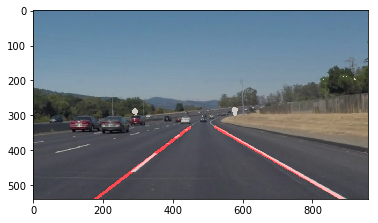

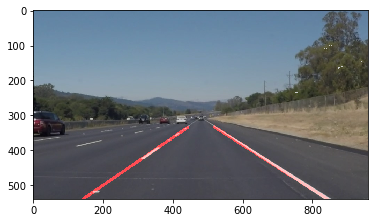

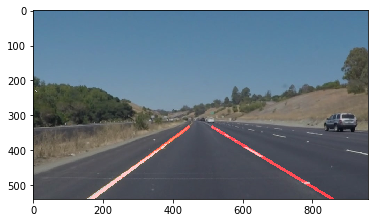

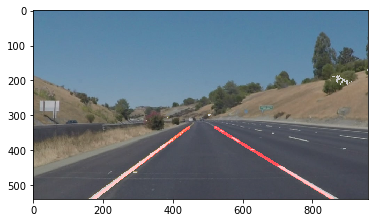

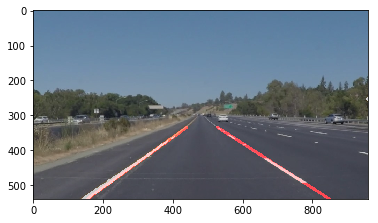

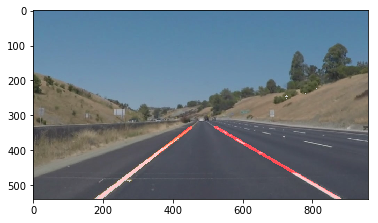

In [12]:
# Define a kernel size for Gaussian Blur
kernel_size = 5

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150

# Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 # minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

#Region on intrest vertices 
ROI = np.array([[(90,540),(500, 300), (960, 540)]], dtype=np.int32)

def set_lane_markings(img):
    img = yellow_process(img) #Convert white to yellow lanes
    gray_img = grayscale(img) 
    blurred  = gaussian_blur(gray_img, kernel_size=kernel_size) 
    edges = canny(blurred, low_threshold, high_threshold)
    ROI_img = region_of_interest(edges,ROI)
    lines_image = hough_lines(ROI_img, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines_image, img, α=0.8, β=1., λ=0.)
    return result

for images in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + images)
    processedImage = set_lane_markings(image)
    plt.imshow(processedImage);
    plt.show();

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`




In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return set_lane_markings(image)

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 23.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.7 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:29<00:00, 23.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 30.1 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflections

### Current Pipeline
   
   - Converts yellow lines to white lines.
   - Converts the image into grey scale. 
   - Apply Gussian Blur.
   - Apply canny edge detection.
   - Select Region of Interest. 
   - Detect lane lines using hough_lines.
   - Apply weighted image.

### Extrapolation Approach
 
 -  Divide all hough lines in left lines and right lines, 
    based on slope and position from centre of image.
      
 -  Reshape lines into a series of point coordinates
  
 -  Use linear regression to find best fit for left and right lanes.
    
 -  For a defined height (y) to calculate x intercepts.
    
 -  Draw lanes using the intercepts. 
    
### Shortcomings

  -   For steeper lanes the extrapolation will not work.
  -   Traffic signs will produce erroneous lines.
    
    This solution does not work for the video challenge, a lot 
    of unwanted hough lines are detected. As a result, the wrong
    coordinates are extrapolated to from spurious lines.
    
    



## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [1]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

NameError: name 'VideoFileClip' is not defined

In [2]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

NameError: name 'HTML' is not defined